# Calculating Activity Onset

## In this notebook, I will:
- import dataset containing multiple spiders and their activity data
- define a threshold for activity onset for each spider every day
- find the first point that threshold is crossed every day
- create a dataframe containing all activity onsets for every spider
- Visualize activity and activity onset through raster plots

In [1]:
import os

os.chdir("/Users/willcatalano/Library/CloudStorage/Box-Box/Spider Data Zoo/Zoo by specie/Metazygia wittfeldae/Activity Onset")


In [2]:
#Set filename as variable to use when saving files
filename = 'Metazygia wittfeldae Monitor 1 Updated_LD'

#Set the threshold for a night where activity occurs too late in minutes. This will help get rid of activity onsets that are inaccurate
late_threshold = 240.0 #300 is midnight in minutes past the time the lights turn off. We define this to be too late for activity onset to be accurate

#Set the fraction of the average nightly activity for a single spider that would be considered 'no activity'. This is to prevent inaccurate activity onset calculations
activity_fraction_threshold = 1/10


In [3]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as matdates
from datetime import timedelta
import os

#Read Spider activity CSV file
df = pd.read_csv(filename + '.csv')
df.set_index('Date-Time', inplace = True)

#Turn date-time column into datetime format
df.index = pd.to_datetime(df.index)

#Determine when lights turn on and off at night
lights_turn_off = df[df['Light'].diff() == -1].index[0]
lights_turn_on = df[df['Light'].diff() == 1].index[0]

## Define necessary functions for calculating activity onset

In [9]:
#This function makes a copy of the original dataframe and calculates the rolling average of activity for every spider 
def create_rolling_df(df):
    
    #copy the original dataframe and drop light column as to only include spider activity in new dataframe
    rolling_df = df.copy().drop('Light', axis = 1)
    
    #calculate rolling average of every column
    rolling_df = rolling_df.rolling(30).mean()
    
    return rolling_df

#This function finds all times when lights turn on and off and returns the index of these occurrences
def find_lights_turn_on_off(df):
    lights_turn_on_off = df[df['Light'].diff() != 0]
    
    #drop the first 2 and last row because these are incomplete days
    on_off = lights_turn_on_off.iloc[2:, :]
    
    #turn the index into a list to loop through
    on_off_list = list(on_off.index.values)
    
    #add the last minute of the last day to this list so that the final day can have activity onset as well
    on_off_list.append(np.datetime64(df.index[-1]))
    
    return on_off_list


#This function groups the created list so that the times where the lights turn off for the night and turn on the next day are elements together
#For example, 2021-07-21 at 7PM will be a list element with 2021-07-22 at 7AM. This way we can loop through the larger list and use indices to call the time night starts and ends.
def create_on_off_sublist(on_off_list):
    on_off_subList = [on_off_list[n:n+2] for n in range(0, len(on_off_list), 2)]
    
    return on_off_subList


#This function will be used to detect days that have minimal activity, preventing "noise" in the activity onset calculations
def find_nightly_activity(df, on_off_sublist):
    #create empty list
    nightly_activity = []
    
    #loop through dark times at night and create new dataframe that contains all the nightly activities that we can average
    for x in on_off_sublist:
        nightly_activity.append(df.loc[x[0]:x[1], :])
    
    #combine list of dfs into one dataframe, drop light column
    nightly_activity = pd.concat(nightly_activity)
    
    return nightly_activity


#This function calculates the threshold for every day and appends the value to a list
#Threshold of activity is defined as the mean, and therefore the first time when activitiy is above the mean is considered activity onset. 
def calculate_activity_onset(df, on_off_sublist, column_name):
    
    #calculate nightly activity as a threshold for days where the spider is inactive
    nightly_activity = find_nightly_activity(df, on_off_sublist)
    
    #loop through dark times to calculate activity onset
    activity_onset_values = []
    for x in on_off_sublist:
        
        #loop through the times it is dark every night
        looped_df = df.loc[x[0]:x[1], :]
        
        #calculate threshold every night
        threshold = looped_df[column_name].mean()
        
        #find all points where rolling average of activity is above the threshold 
        threshold_crossings = looped_df[looped_df[column_name] > threshold].index
        
        #append first threshold crossing to the activity onset list every day
        if len(threshold_crossings) > 0:
            
            #check if enough activity happens in that day for it to be considered a full day of activity
            if looped_df[column_name].mean() > activity_fraction_threshold * nightly_activity[column_name].mean():
                
                activity_onset_values.append(threshold_crossings[0])
                
            else:
                activity_onset_values.append('NaN')
        else:
            activity_onset_values.append('NaN')  
    
    return activity_onset_values


#this function loops through all column names and calculates activity onset for every day for every spider
def calculate_activity_onset_multiple_spiders(df, rolling_df):
    #create list of spider names
    spider_names = list(rolling_df)
    
    #create empty dictionary to store activity onset values in
    mult_spiders_activity_onset_dict = {}
    
    #create list of all dates and times where lights turn on and off
    transition_indexes_list = find_lights_turn_on_off(df)
    
    #create sublists containing each day of light switch indeces so they are easy to work with
    on_off_sublist = create_on_off_sublist(transition_indexes_list)
    
    #loop through all columns
    for i in spider_names:
        mult_spiders_activity_onset_values = calculate_activity_onset(rolling_df, on_off_sublist, i)
    
        #create dictionary key and element containing spider name and activity onset
        mult_spiders_activity_onset_dict[i] = mult_spiders_activity_onset_values
        
    return mult_spiders_activity_onset_dict


#Create activity onset dataframe function
def create_activity_onset_df(mult_spiders_activity_onset_dict, lights_turn_off):

    #create dataframe from dictionary previously created
    mult_spiders_activity_onset_df = pd.DataFrame.from_dict(mult_spiders_activity_onset_dict)

    #subtract the time the lights turn off from every value in df
    subtracted_df = mult_spiders_activity_onset_df - lights_turn_off
    
    #create list of spiders
    spider_names = list(subtracted_df)
    
    #loop through every column to extract activity onset time
    for x in spider_names: 
        
        #extract minutes and hours from every value in each column to get activity onset in relation to lights turn off
        subtracted_df[x] = subtracted_df[x].dt.seconds/60
        
        #replace every activity onset that occurs past midnight with NaN, as these are likely incorrect calculations
        subtracted_df[x] = np.where(subtracted_df[x] > late_threshold, 'NaN', subtracted_df[x])
    
    #list of unique dates to make the index of the subtracted df
    list_of_dates = list(mult_spiders_activity_onset_df.iloc[:, 1].dt.date)
    
    #set the unique dates as the index
    subtracted_df.index = list_of_dates
    
    #turn all values into integers instead of strings
    subtracted_df = subtracted_df.apply(pd.to_numeric, errors='coerce')
    
    #save dataframe as csv file
    subtracted_df.to_csv(filename + ' Activity Onset Values.csv')
    
    return subtracted_df    

## Define necessary functions for creating raster plots to visualize activity onset

In [5]:
#This function creates a list of dataframes for each date so that each date may be plotted individually
def create_list_of_df(df):
    #find all unique days
    all_days = np.unique(list(df.index.date))
    
    #create empty list to append to 
    bracket = []
    
    #loop through dataframe and create new df for every day
    for x in range(len(all_days)):
        bracket.append(df[df.index.date==all_days[x]])
         
    return bracket


#This function finds all times when lights turn on and off and returns the index of these occurrences
#We need a new function doing this for the raster plot because the raster plot requires the first time the lights turn on
def find_lights_turn_on_off_for_raster_plot(df):
    
    #find indices where lights turn on and off
    lights_turn_on_off = df[df['Light'].diff() != 0]
    lights_turn_on_off = lights_turn_on_off.append(df.iloc[-1])
    
    #drop the first and last row because these are the beginning and end of the days
    on_off = lights_turn_on_off.iloc[1:-1, :]
    
    #turn the index into a list to loop through
    on_off_list = list(on_off.index.values)
    
    return on_off_list


#This function sets up the raster plot with subplots, adjusts the axes, and sets datetime for the x axis
def set_up_raster_plot(rolling_df, column_name):

    #create list of dataframes each containing a unique date which will be used to plot the data on the graph
    list_of_df = create_list_of_df(rolling_df)
    
    #find all unique days to make the y labels of the graph
    all_days = np.unique(list(df.index.date))
    
    #set up fig and axis with the number of subplots being the number of unique days, set figsize
    fig, axs = plt.subplots(nrows = len(list_of_df), sharey = True, figsize = (10, 13))
    
    #adjust space between subplots
    plt.subplots_adjust(hspace = 0)
    
    #set labels for the x and y axis on the graph, as well as title
    axs[-1].set_xlabel('Time of Day')
    axs[0].title.set_text('Activity for ' + str(column_name) + ' Throughout Each Day')
    
    #adjust ticks
    for x in range(len(axs)-1):
        axs[x].set_yticks([])
        axs[x].set_xticks([])
    
    #set up the x axis to have time of day 
    hour_locator = matdates.HourLocator(byhour = range(24), interval = 2)
    axs[-1].xaxis.set_major_locator(hour_locator)
    axs[-1].xaxis.set_major_formatter(matdates.DateFormatter('%H:%M'))
    
    return fig, axs, list_of_df, all_days


#This function plots the activity data on the raster plot, highlights the times where lights were off, and plots a line for activity onset
def plot_data_on_raster_plot(rolling_df, activity_onset_df, activity_onset_times_df, column_name, light_switch_times):
    
    #use function that set up raster plot to define fig and axs variables
    fig, axs, list_of_df, all_days = set_up_raster_plot(rolling_df, column_name)
    
    #create list of activity onset times so they can be graphed
    activity_onset_times_list = list(activity_onset_times_df[column_name][:])
    
    activity_onset_df = activity_onset_df.apply(pd.to_numeric, errors='ignore')
    
    #set up for loop that plots each day on each subplot
    for i in range(len(axs)):
        #plot each day
        axs[i].plot_date((list_of_df[i].index.values), list_of_df[i][column_name], color = 'black', linestyle = 'solid',
                        marker = 'None')
        
        #Make y labels the date
        axs[i].set_ylabel(all_days[i])
        
        #Set the margins
        axs[i].margins(x = 0.001)
        
        #add vertical line indicating activity onset, ignore days where activity onset is past midnight, as these are likely arhythmic
        if activity_onset_df[column_name][i] < late_threshold:
            axs[i].axvline(x = activity_onset_times_list[i], color = "red", linestyle = '--')
        
        #add shading for when it is dark for each subplot
        axs[i].axvspan(list_of_df[i].index[0], light_switch_times[i][0], alpha = 0.5, color = 'grey')
        axs[i].axvspan(light_switch_times[i][1], list_of_df[i].index[-1], alpha = 0.5, color = 'grey')
    
    #ignore warnings
    plt.rcParams.update({'figure.max_open_warning': 0})
        
    #save the figure as a png file
    plt.savefig(filename + ' ' + column_name + ' Raster Plot.png')
    
    

## Calculate Activity Onset for Every Spider and Create Dataframe

In [10]:
#Create rolling dataframe from original df
rolling_df = create_rolling_df(df)

#Create dictionary containing all activity onset values for every spider
mult_spiders_activity_onset_dict = calculate_activity_onset_multiple_spiders(df, rolling_df)

#Create a dataframe from the dictionary and subtract the activity onset times from when the lights turn off at night
activity_onset_df = create_activity_onset_df(mult_spiders_activity_onset_dict, lights_turn_off)

#display activity onset dataframe
display(activity_onset_df)

,Monitor 1 Spider 1,Monitor 1 Spider 2,Monitor 1 Spider 3,Monitor 1 Spider 4,Monitor 1 Spider 5,Monitor 1 Spider 6,Monitor 1 Spider 7,Monitor 1 Spider 8,Monitor 1 Spider 9,Monitor 1 Spider 10,...,Monitor 1 Spider 21,Monitor 1 Spider 23,Monitor 1 Spider 25,Monitor 1 Spider 26,Monitor 1 Spider 27,Monitor 1 Spider 28,Monitor 1 Spider 29,Monitor 1 Spider 30,Monitor 1 Spider 31,Monitor 1 Spider 32
2017-04-21,30.0,68.0,38.0,61.0,36.0,33.0,54.0,33.0,43.0,63.0,...,46.0,128.0,51.0,36.0,32.0,73.0,35.0,182.0,25.0,33.0
2017-04-22,43.0,37.0,41.0,59.0,39.0,25.0,27.0,42.0,34.0,NaN,...,26.0,91.0,33.0,37.0,34.0,54.0,31.0,54.0,34.0,37.0
2017-04-23,28.0,35.0,26.0,63.0,31.0,38.0,36.0,45.0,38.0,36.0,...,21.0,88.0,47.0,23.0,28.0,49.0,26.0,45.0,24.0,33.0
2017-04-24,24.0,27.0,29.0,35.0,34.0,28.0,34.0,21.0,28.0,47.0,...,32.0,70.0,47.0,36.0,28.0,51.0,30.0,29.0,24.0,27.0
2017-04-25,37.0,36.0,34.0,42.0,36.0,26.0,33.0,25.0,34.0,54.0,...,32.0,77.0,67.0,27.0,24.0,52.0,18.0,44.0,37.0,43.0


## Create Raster Plots to Visualize Activity Onset

In [ ]:
#Create list of times that lights turn on and off so that the raster plot is shaded
light_switch_times_list = find_lights_turn_on_off_for_raster_plot(df)

#Combine list elements with the same date into one element so that they can be looped through
light_switch_times = create_on_off_sublist(light_switch_times_list)

#Make dataframe from activity onset times so that they can be plotted on the graph
activity_onset_times_df = pd.DataFrame(mult_spiders_activity_onset_dict)

#Create list of spider names to loop through to create raster plots
column_names = list(activity_onset_df)

#loop through spiders and create raster plots
for x in column_names:
    plot_data_on_raster_plot(rolling_df, activity_onset_df, activity_onset_times_df, x, light_switch_times)

## Define Function that Takes Activity Onset Dataframe and puts it into the Master File

In [49]:
monitor = 'Monitor 1'
master_df_name = 'all_spider_and_fly_summary.csv'
species = 'Metazygia wittfeldae'


#this function will loop through the folders in the spider data zoo to gather spider names
directory = "/Users/willcatalano/Library/CloudStorage/Box-Box/Spider Data Zoo/Zoo by specie"

def get_species_names(directory):
    
    #create empty list to append names
    species_names = []
    
    #loop through folders in given directory
    for folder in os.listdir(directory):
        
        #only select folders starting with capital letter, as these are the species names
        if folder == folder.capitalize():
        
            #append names of files to empty list
            species_names.append(folder)
        
    
    return species_names

#this function will take activity onset values and calculate the average activity onset for each individual
def transfer_activity_onset(species, monitor):
    
    #create empty list to append means to
    activity_onset_medians_list = []
    
    #change directory to the folder containing the activity onset file
    os.chdir("/Users/willcatalano/Library/CloudStorage/Box-Box/Spider Data Zoo/Zoo by specie/" + species + "/Activity Onset")
    
    #create dataframe containing the activity onset values
    activity_onset_file = pd.read_csv(species + ' ' + monitor + ' Updated_LD Activity Onset Values.csv')
    
    #remove date column
    activity_onset_file = activity_onset_file.iloc[: , 1:]
    
    #take median activity onset for each spider and append to list
    column_names = list(activity_onset_file)
    for x in column_names:
        mean_activity_onset = np.nanmedian(activity_onset_file[x])
        activity_onset_medians_list.append(mean_activity_onset)
    
    #append averages as the last row of the dataframe
    activity_onset_file.loc[len(activity_onset_file)] = activity_onset_medians_list
    
    return activity_onset_file

list_of_spiders = list(mean_activity_onset_df)

#this function will take the sem of every spider
def calculate_sem(species, monitor, activity_onset_file):
    
    #create empty list to append means to
    activity_onset_sem_list = []
    
    #calculate sem of activity onset for each spider and append to list
    column_names = list(activity_onset_file)
    for x in column_names:
        sem_activity_onset = np.std(activity_onset_file[x], ddof=1) / np.sqrt(np.size(activity_onset_file[x]))
        activity_onset_sem_list.append(sem_activity_onset)
    
    #append sems as the last row of the dataframe
    activity_onset_file.loc[len(activity_onset_file)] = activity_onset_sem_list
    
    return activity_onset_file

median_activity_onset_df = transfer_activity_onset(species, monitor)
median_activity_onset_df_w_sem = calculate_sem(species, monitor, mean_activity_onset_df)


#This function will take the correct species and monitor and return it as its own dataframe
def get_species_monitor_values_from_master(master_df_name, list_of_spiders, species):
    
    #change the directory to get to the master document 
    os.chdir("/Users/willcatalano/Library/CloudStorage/Box-Box/Spider activity analysis Fall 2022/Activity Onset/Sandbox folder for Spider Data Organization/All spider data merged")
    
    #import the master document
    master_df = pd.read_csv(master_df_name)
    
    #select for species that is being replaced
    master_only_one_species = master_df[(master_df['Specie Name'] == species) & (master_df['Conditions'] == 'LD')]
    
    #select portion of df that contains the spiders were worried about
    monitor_species_master = master_only_one_species.loc[master_only_one_species['Spider ID'].isin(list_of_spiders)]
    
    return monitor_species_master, master_df

metazygia_m1, master_df = get_species_monitor_values_from_master(master_df_name, list_of_spiders, species)



#This function will replace the activity onset values that are currently in the df and replace them with the correct values
def change_activity_onset_values(monitor_species_master, median_activity_onset_df):      

    #Get the average activity onset for each spider
    median_activity_onsets = median_activity_onset_df.iloc[-2, :]
    
    #replace the master document activity onset
    monitor_species_master['Mean Activity Onset'] = list(median_activity_onsets)
    
    return monitor_species_master

replaced_activity_onsets = change_activity_onset_values(metazygia_m1, median_activity_onset_df_w_sem)

replaced_activity_onsets


,Specie Name,Spider ID,Conditions,Is Stationary,LombSc Period,LombSc Amplitude,LombSc p-value,Masking,Mean Activity Onset,DiNoc Ratio,Activity Rest Ratio,Mean Vector Length,Mean Vector Angle
700,Metazygia wittfeldae,Monitor 1 Spider 1,LD,1.0,23.858661,3463.947923,0.000000e+00,NaN,3.600527,-1.948302,0.174551,0.699400,-25.467062
701,Metazygia wittfeldae,Monitor 1 Spider 2,LD,1.0,24.244339,17960.212410,0.000000e+00,NaN,4.704701,-1.968857,0.219099,0.788889,-26.193667
702,Metazygia wittfeldae,Monitor 1 Spider 3,LD,1.0,23.670387,11781.425790,0.000000e+00,NaN,3.747521,-1.955786,0.322800,0.722130,-14.157219
703,Metazygia wittfeldae,Monitor 1 Spider 4,LD,1.0,24.342715,10419.362980,0.000000e+00,NaN,5.990779,-1.966046,0.356699,0.635362,9.598347
704,Metazygia wittfeldae,Monitor 1 Spider 5,LD,1.0,22.771896,3480.132789,0.000000e+00,NaN,3.889528,-1.945309,0.154031,0.671291,-15.133155
705,Metazygia wittfeldae,Monitor 1 Spider 6,LD,1.0,23.858661,3241.930960,0.000000e+00,NaN,3.303235,-1.955274,0.193634,0.534267,-1.214098
706,Metazygia wittfeldae,Monitor 1 Spider 7,LD,1.0,23.393482,3852.546231,0.000000e+00,NaN,4.131925,-1.915244,0.157184,0.678742,-9.703588
707,Metazygia wittfeldae,Monitor 1 Spider 8,LD,1.0,22.685784,1069.409469,0.000000e+00,NaN,3.805033,-1.887168,0.074466,0.626898,-30.960156
708,Metazygia wittfeldae,Monitor 1 Spider 9,LD,1.0,22.685784,3103.365284,0.000000e+00,NaN,3.899549,-1.875842,0.168073,0.583936,-10.393420
709,Metazygia wittfeldae,Monitor 1 Spider 10,LD,1.0,23.670387,896.114634,0.000000e+00,NaN,5.456576,-1.941704,0.089094,0.755284,-30.056726


## Visualize spider onset distributions

In [36]:
new_df = activity_onset_df.stack(dropna = True).reset_index(level=0, drop=True)

new_df = pd.DataFrame(new_df)

new_df['Activity Onset Median'] = new_df.iloc[:, 0]

new_df = new_df.sort_index()
new_df = new_df.drop(0, axis = 1)

#new_df['SEM'] = 

new_df

,Activity Onset Median
Monitor 1 Spider 1,30.0
Monitor 1 Spider 1,28.0
Monitor 1 Spider 1,24.0
Monitor 1 Spider 1,37.0
Monitor 1 Spider 1,43.0
...,...
Monitor 1 Spider 9,38.0
Monitor 1 Spider 9,28.0
Monitor 1 Spider 9,34.0
Monitor 1 Spider 9,34.0


(0.0, 175.0)

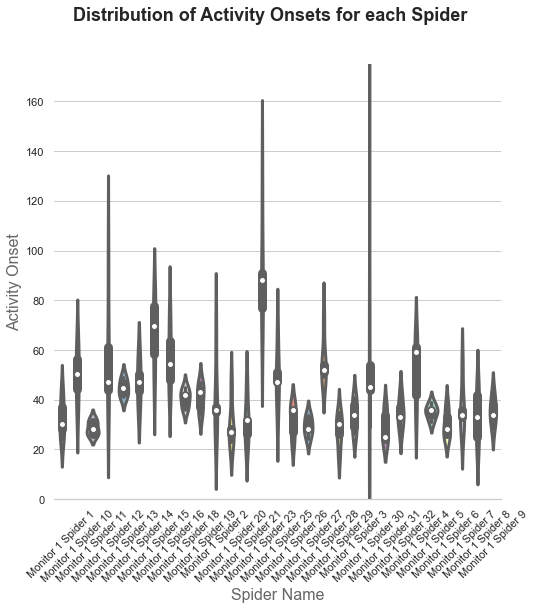

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(8, 8))

# Show each distribution with both violins and points
sns.violinplot(x = new_df.index, y = new_df['Activity Onset Median'], inner="box", palette="Set3", cut=2, linewidth=3)

sns.despine(left=True)

f.suptitle('Distribution of Activity Onsets for each Spider', fontsize=18, fontweight='bold')
ax.set_xlabel("Spider Name",size = 16,alpha=0.7)
ax.set_ylabel("Activity Onset Median",size = 16,alpha=0.7)
plt.xticks(rotation=45)
plt.ylim([0,175])